# Compare ISM across PPIF enhancer with experimental Variant-FlowFISH results

In [39]:
import pandas as pd
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import re
import numpy as np

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

### Coordinates of region

Coordinates: PPIF locus (hg19 chr10:81,037,448-81,124,761), PPIF enhancer (chr10:81,045,48981,047,143), PPIF promoter (chr10:81,106,967-81,107,535).  

**_hg19_**
- chr10:81037448-81124761 (locus)
- chr10:81045489-81047143 (enhancer)
- chr10:81106967-81107535 (promoter) : 569 bp

**_hg38_**
- chr10:79277691-79365005 (locus)
- chr10:79285732-79287386 (enhancer)
- chr10:79347211-79347779 (promoter)

### Read in experimental results

In [18]:
variantF = pd.read_csv('variantflowfish_supp8.csv')
variantF = variantF[variantF['Screen'] == 'PPIF Enhancer Tiling Mutagenesis'] # enhancer screen only
variantF[['chrom', 'position', 'sequence_change']] = variantF['VariantID'].str.split(':', expand=True)
variantF[['original_sequence', 'edited_sequence']] = variantF['sequence_change'].str.split('>', expand=True)
variantF = variantF.drop('sequence_change', axis=1)
variantF['position'] = variantF['position'].astype(int)
variantF = variantF.sort_values(by='position', ascending=True)
position_means = variantF.groupby('position')['% change to PPIF expression'].mean().reset_index()

### Convert coordinates to hg38

In [23]:
hg38_lift = pd.read_csv('enhancer_coords_mean_hg38.bed', sep='\t', header=None)
hg38_coords = hg38_lift[1].tolist()
position_means['position_hg38'] = hg38_coords

### Read ISM

In [30]:
ism = pd.read_csv('ppif_enhancer_ism_aggregate_july24.csv', index_col=0, header=0) 
def clean_column_name(col):
    return ''.join(re.findall(r'[ACTG]', col))
ism.columns = [clean_column_name(col) for col in ism.columns]
mean_ism = ism.mean(axis=0)
enhancer_start = 79285732
enhancer_end = 79287386
ismR = pd.DataFrame([np.arange(enhancer_start, enhancer_end), mean_ism]).T
ismR.columns = ['position', 'ism']
ismR['position'] = ismR['position'].astype(int)

### Merge experimental results 

In [43]:
mergedF = pd.merge(ismR, position_means, left_on='position', right_on='position_hg38', how='outer')
df = mergedF[['position_x', 'ism', '% change to PPIF expression']]
df['% change to PPIF expression'] = pd.to_numeric(df['% change to PPIF expression'], errors='coerce')

/tmp/ipykernel_60452/3193627888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['% change to PPIF expression'] = pd.to_numeric(df['% change to PPIF expression'], errors='coerce')


### Plot results

/tmp/ipykernel_60452/1641439930.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rolling_avg_ism'] = df['ism'].rolling(window=window_size, center=True, min_periods=1).mean()
/tmp/ipykernel_60452/1641439930.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rolling_avg_ppif'] = df['% change to PPIF expression'].rolling(window=window_size, center=True, min_periods=1).mean()


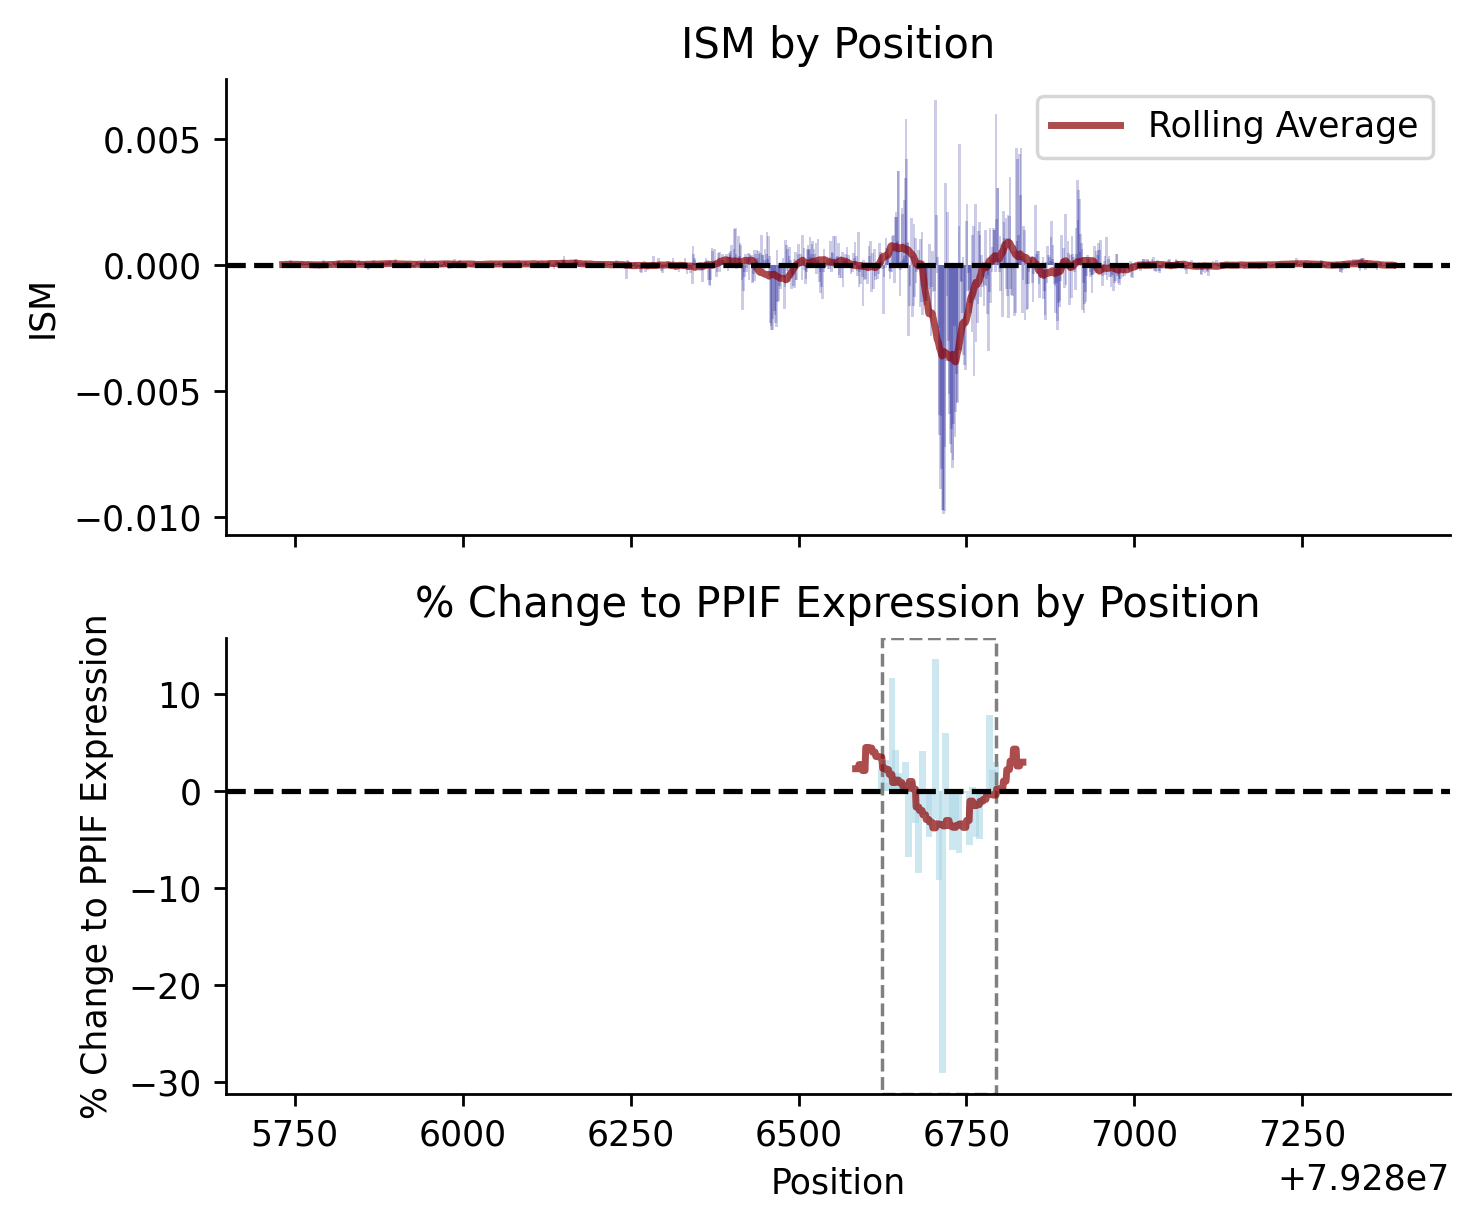

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,5), sharex=True, dpi=250)

# Plot for the first subplot (ISM)
ax1.bar(df['position_x'], df['ism'], color='darkblue', alpha=0.2, width=4)

# Calculate and plot the rolling average for ISM
window_size = 50  # Adjust this value to change the smoothness of the rolling average
df['rolling_avg_ism'] = df['ism'].rolling(window=window_size, center=True, min_periods=1).mean()
ax1.plot(df['position_x'], df['rolling_avg_ism'], color='darkred',alpha=.7, linewidth=2, label='Rolling Average')

ax1.set_ylabel('ISM', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_title('ISM by Position')
ax1.axhline(y=0, c='black', linestyle='dashed')
ax1.legend()

# Plot for the second subplot (% change to PPIF expression)
ax2.bar(df['position_x'], df['% change to PPIF expression'], alpha=0.6, color='lightblue', width=10)

# Calculate and plot the rolling average for % change to PPIF expression
window_size =80
df['rolling_avg_ppif'] = df['% change to PPIF expression'].rolling(window=window_size, center=True, min_periods=1).mean()
ax2.plot(df['position_x'], df['rolling_avg_ppif'], color='darkred',alpha=.7, linewidth=2)

ax2.set_xlabel('Position')
ax2.set_ylabel('% Change to PPIF Expression', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_title('% Change to PPIF Expression by Position')
ax2.axhline(y=0, c='black', linestyle='dashed')

# Add dashed box around min to max
min_pos = position_means['position_hg38'].min()
max_pos = position_means['position_hg38'].max()
rect = plt.Rectangle((min_pos, ax2.get_ylim()[0]), max_pos - min_pos, ax2.get_ylim()[1] - ax2.get_ylim()[0], 
                     fill=False, linestyle='--', edgecolor='grey')
ax2.add_patch(rect)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
